## Purpose

The architecture of the network is already shared. The object of this assignment is to perform the following tasks for CIFAR10 dataset:
* Apply Cutout image augmentation
* Use LR Finder to find the best learning rate to start with
* Use SGD optimizer with mementum
* Train the model for 100 epochs
* Keep verbose=0, so training logs. Only the model summary has to be displayed
* Print the top accuracy for validation set
* Find 25 misclassified images from the validation set and display their predicted class vs ground truth
* Generate and display GradCAM for those misclassified images


## Process the dataset and CutOut Function

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(trainX, trainy), (testX, testy) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  trainX.shape
num_test, _, _, _ =  testX.shape
num_classes = len(np.unique(trainy))

170500096/170498071 [==============================] - 17s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (trainX.shape)

10
50000
(50000, 32, 32, 3)


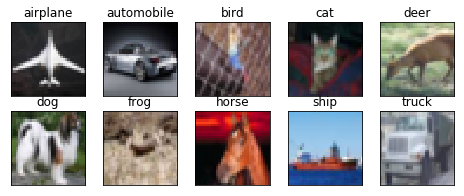

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(trainy[:]==i)[0]
    features_idx = trainX[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Model Builder

In [0]:
# Define the model
def build_model(optimizer_fn):
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Convolution2D(10, 1, 1))

  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())


  model.add(Activation('softmax'))

  model.compile(optimizer=optimizer_fn, loss='categorical_crossentropy', metrics=['accuracy'])

  return model


In [13]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = build_model(optimizer_fn=sgd)
model.summary()

W0723 05:34:18.008977 140685699229568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0723 05:34:18.015829 140685699229568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 05:34:18.018984 140685699229568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

## Find Best starting Learning Rate using LRFinder

Using LRFinder as given in the assignment.

In [12]:
!pip install git+https://github.com/surmenok/keras_lr_finder.git

  Cloning https://github.com/surmenok/keras_lr_finder.git to /tmp/pip-req-build-i737pu2j
  Running command git clone -q https://github.com/surmenok/keras_lr_finder.git /tmp/pip-req-build-i737pu2j
  Stored in directory: /tmp/pip-ephem-wheel-cache-n14hvzta/wheels/b6/38/23/51b94c019ef704f8b9679f9848a3f766865304d15af56854a3
Successfully built keras-lr-finder


In [0]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

Epoch 1/1
75/98 [=====================>........] - ETA: 3s - loss: 2.6940 - acc: 0.2212

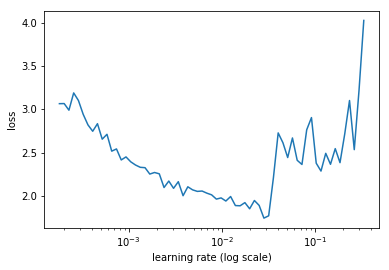

In [50]:
generator = datagen.flow(X_train, Y_train, batch_size=512,shuffle=True)
lr_finder.find_generator(generator, 0.0001, 10.1, epochs=1, steps_per_epoch=None,)
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=5)

I count not find a way, to print the best LR from the diagram automatically. I will have to look into matplotlib more in detail to come up with that solution. For now, I closely examined the image and found that, from the begining the loss was steadily increasing until around 0.055 (mid of 0.1 and 0.01) and then it started shooting up. With a more close look, we can see that the lowest LR is a little left to 0.055 and hence I chose **0.54** as starting LR for next set of training.

## Train the model with LR=0.054 for 100 Epochs

In [34]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.054, decay=1e-6, momentum=0.9, nesterov=True)

model = build_model(optimizer_fn=sgd)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
__________

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1),)
datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
datagen.fit(X_train)
datagen_validation.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=512,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, validation_data=<keras_pre..., validation_steps=19, verbose=0, epochs=100)`
  if sys.path[0] == '':


Model took 1809.85 seconds to train


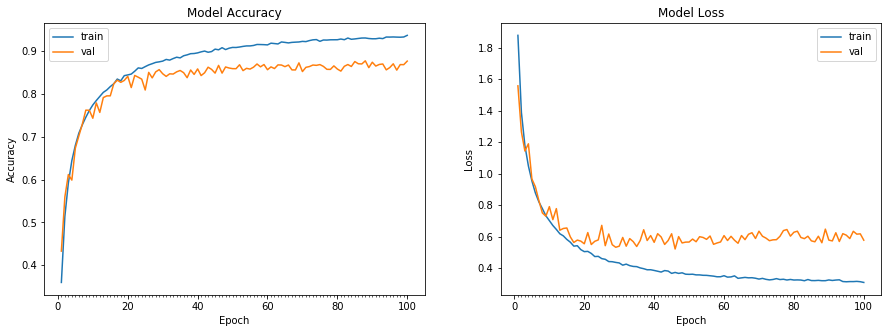

Accuracy on test data is: 25.75


In [38]:
STEP_SIZE_TRAIN=train_iterator.n//train_iterator.batch_size
STEP_SIZE_VALID=validation_iterator.n//validation_iterator.batch_size

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_iterator,
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 nb_epoch = 100, 
                                 validation_data = validation_iterator, 
                                 validation_steps=STEP_SIZE_VALID,
                                 verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

## Print the best Validation Accuracy

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test_bkp, Y_test_bkp = X_test, Y_test
Y_test = np_utils.to_categorical(Y_test, 10)
datagen_validation = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen_validation.fit(X_train)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=X_test.shape[0], shuffle=False)
X_test, Y_test = validation_iterator.next()

In [41]:
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

Accuracy on test data is: 87.63


## Display 25 Missclassified Images from Validation set with predicted class vs ground truth

In [0]:
y_pred = model.predict(X_test)

In [88]:
y_pred_digits=np.argmax(y_pred,axis=1)
y_pred_digits[:9]

array([3, 8, 8, 0, 6, 6, 1, 2, 3])

In [89]:
Y_test_digits=np.argmax(Y_test,axis=1)
Y_test_digits[:9]

array([3, 8, 8, 0, 6, 6, 1, 6, 3])

In [0]:
mis_class=[]

i=0
for i in range(len(Y_test_digits)):
    if(Y_test_digits[i]) != y_pred_digits[i]:
        mis_class.append(i)
    if(len(mis_class)==26):
        break

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

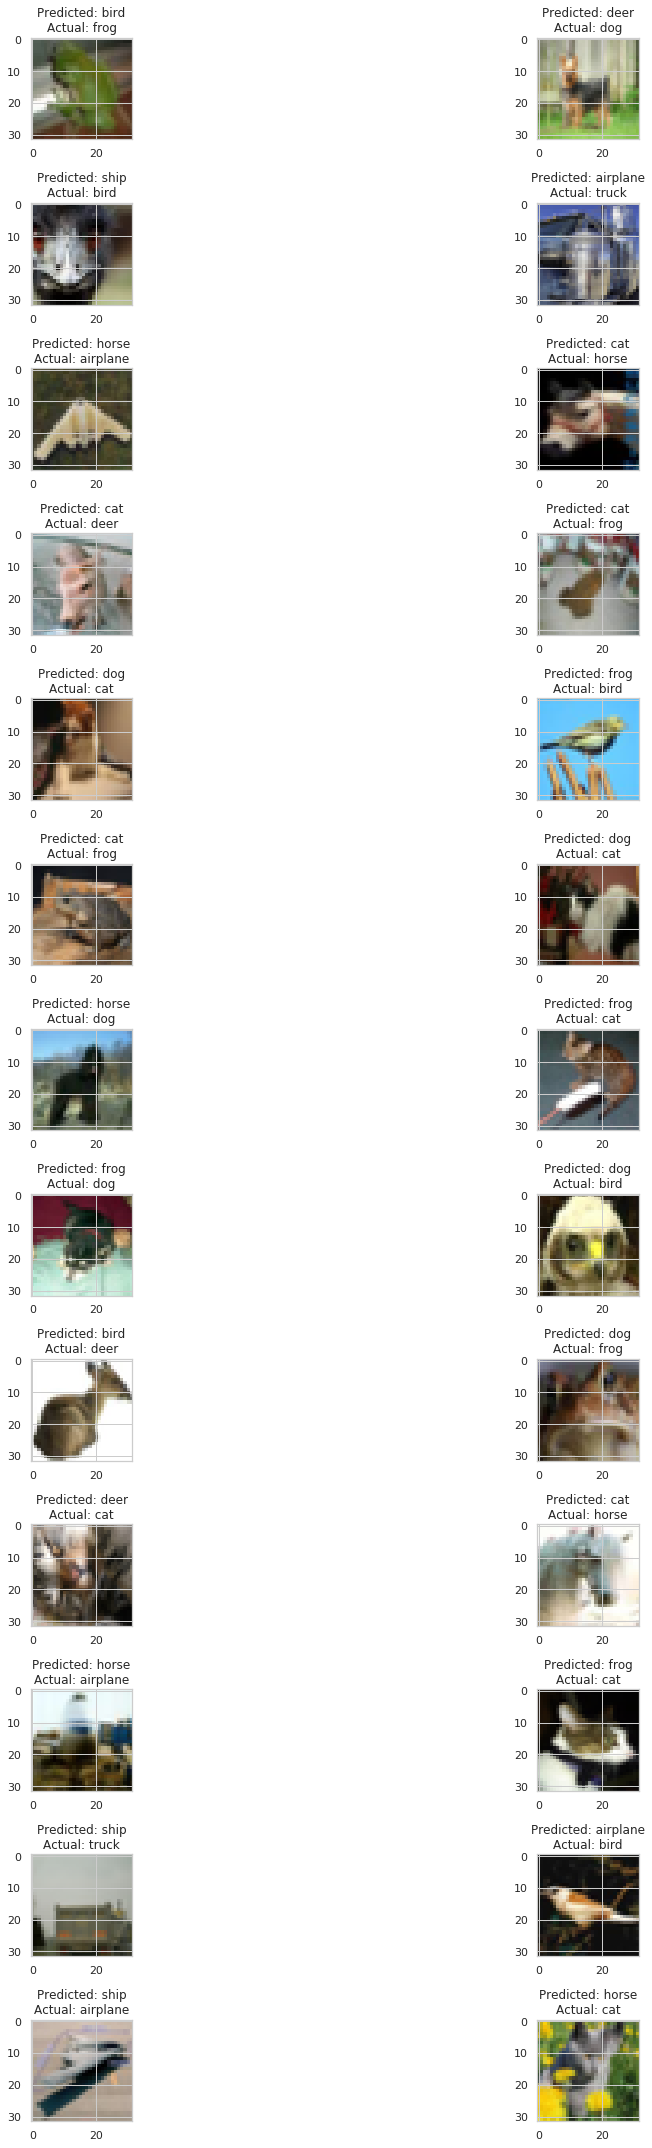

In [93]:
class_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

count=0
fig,ax=plt.subplots(13,2)
fig.set_size_inches(30,30)
for i in range (13):
    for j in range (2):
        ax[i,j].imshow(X_test_bkp[mis_class[count]])
        actual = class_names[(Y_test_bkp[mis_class[count]])[0]]
        predicted = class_names[y_pred_digits[mis_class[count]]]
        ax[i,j].set_title("Predicted: "+ str(predicted)+ "\n" + "Actual: "+str(actual))
        plt.tight_layout()
        count+=1

## Generate and Display GradCAM for those 25 misclassified images

In [0]:
import cv2
from google.colab.patches import cv2_imshow


def gradcam_display(img_idx, layer):
  im = X_test_bkp[img_idx]
  x = X_test[img_idx]
  x = np.expand_dims(x, axis=0)

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  channels = grads.shape[-1]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  im = cv2.resize(im, (128, 128))

  heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(im, 0.5, heatmap, 0.5, 0)
  
  return np.hstack([im, superimposed_img])

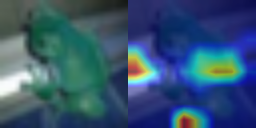

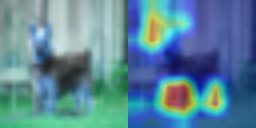

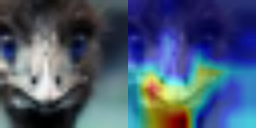

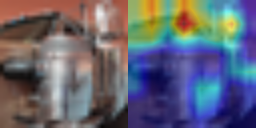

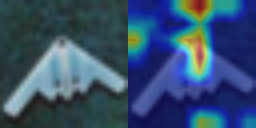

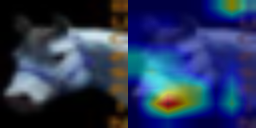

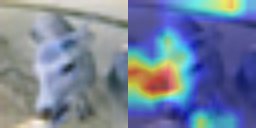

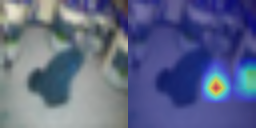

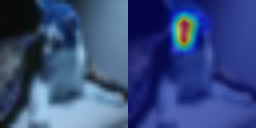

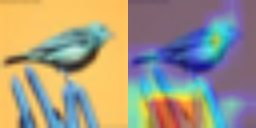

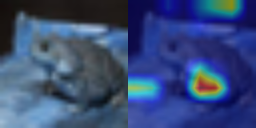

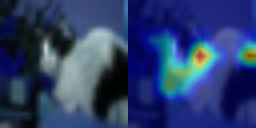

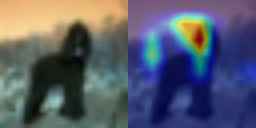

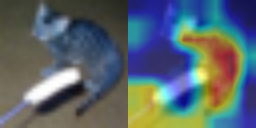

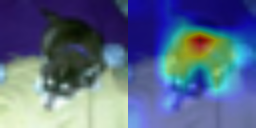

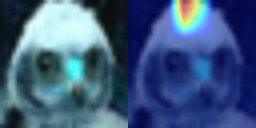

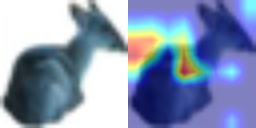

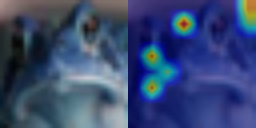

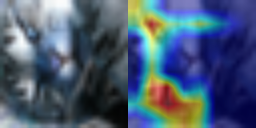

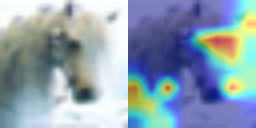

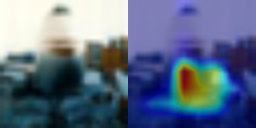

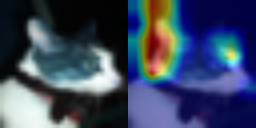

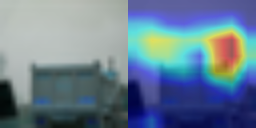

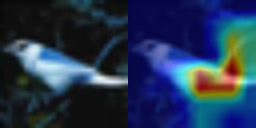

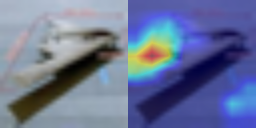

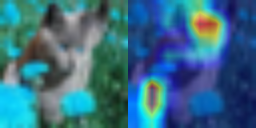

In [119]:
for i in mis_class:
  images_stack = gradcam_display(i, "conv2d_35")
  cv2_imshow(images_stack)